### Plots of inversions


In [2]:
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import os
import warnings

In [3]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')
        
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [4]:
ak = np.load("../carmen/daily_numpys/AK_CPOM/FB_interp_2018-2019_25km_20190422.npy")
cs = np.load("../carmen/daily_numpys/CS2_CPOM/FB_interp_2018-2019_25km_20190422.npy")

lon_g = np.load("../../new_lon_25km.npy")
lat_g = np.load("../../new_lat_25km.npy")

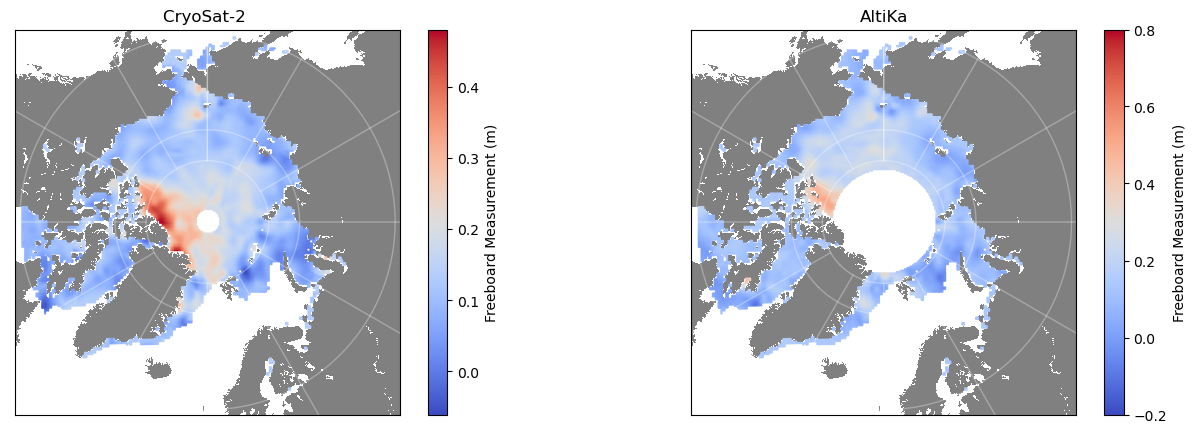

In [5]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=cs, cmap="coolwarm")
plt.colorbar(label=r'Freeboard Measurement (m)')
plt.title("CryoSat-2 ")

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ak, cmap="coolwarm", vmin=-0.2, vmax=0.8)
plt.colorbar(label=r'Freeboard Measurement (m)')
plt.title('AltiKa')

plt.show()

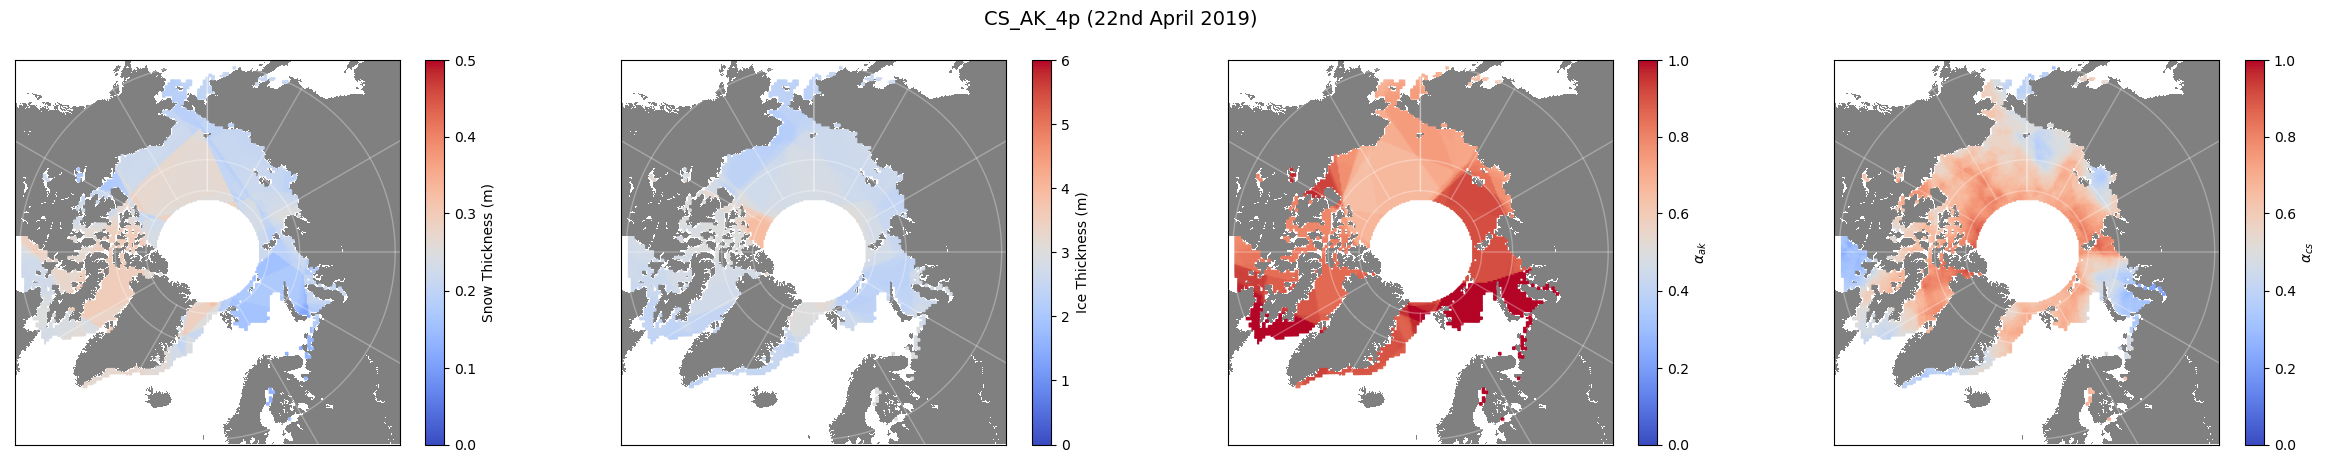

In [13]:
snow = np.loadtxt("images/FB_interp_2018-2019_25km_20190422.npy_snow")
ice = np.loadtxt("images/FB_interp_2018-2019_25km_20190422.npy_ice")
ak_alpha = np.loadtxt("images/FB_interp_2018-2019_25km_20190422.npy_ak_penetration")
cs_alpha = np.loadtxt("images/FB_interp_2018-2019_25km_20190422.npy_cs2_penetration")

snow = mask_observations(ak, snow)
ice = mask_observations(ak, ice)
ak_alpha = mask_observations(ak,ak_alpha)
cs_alpha = mask_observations(ak,cs_alpha)

fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(141)

fig.suptitle("CS_AK_4p (22nd April 2019)", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=snow, cmap="coolwarm", vmin=0, vmax=0.5)
plt.colorbar(label=r'Snow Thickness (m)')

ax = fig.add_subplot(142)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ice, cmap="coolwarm", vmin=0, vmax=6)
plt.colorbar(label=r'Ice Thickness (m)')

ax = fig.add_subplot(143)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ak_alpha, cmap="coolwarm", vmin=0, vmax=1)
plt.colorbar(label=r'$\alpha_{ak}$')

ax = fig.add_subplot(144)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=cs_alpha, cmap="coolwarm", vmin=0, vmax=1)
plt.colorbar(label=r'$\alpha_{cs}$')


plt.show()

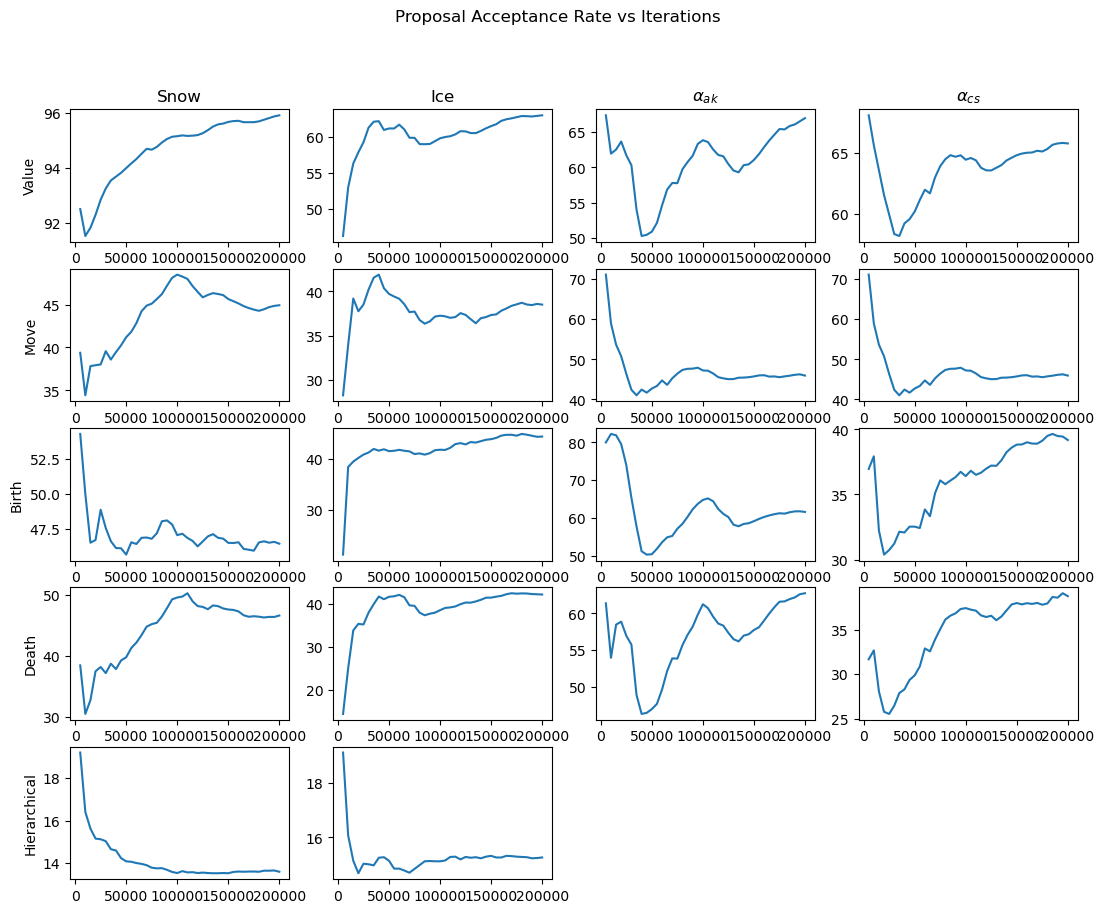

In [7]:
file = 'results/log.txt-000'

iterations = np.arange(5000,200001,5000)

keywords = ["Value", "Move", "Birth", "Death", "Hierarchical"]

rate = {key: {"snow": [], "ice": [], "cs":[], "ak": []} for key in keywords}

with open(file) as f:
    for line in f:
        data = line.split()

        for key in keywords:
            if key in line:
                rate[key]["snow"].append(float(data[4]))
                rate[key]["ice"].append(float(data[9]))
                if key !="Hierarchical":
                    rate[key]["ak"].append(float(data[14]))
                    rate[key]["cs"].append(float(data[19]))
            


plt.figure(figsize=(13,10))
plt.suptitle('Proposal Acceptance Rate vs Iterations')

plt.subplot(5,4,1)
plt.plot(iterations, rate["Value"]["snow"], '-')
plt.ylabel("Value")
plt.title('Snow')

plt.subplot(5,4,2)
plt.plot(iterations, rate["Value"]["ice"],'-')
plt.title('Ice')

plt.subplot(5,4,3)
plt.plot(iterations, rate["Value"]["ak"],'-')
plt.title(r'$\alpha_{ak}$')

plt.subplot(5,4,4)
plt.plot(iterations, rate["Value"]["cs"],'-')
plt.title(r'$\alpha_{cs}$')

plt.subplot(5,4,5)
plt.plot(iterations, rate["Move"]['snow'],'-')
plt.ylabel("Move")

plt.subplot(5,4,6)
plt.plot(iterations, rate["Move"]['ice'],'-')

plt.subplot(5,4,7)
plt.plot(iterations, rate["Move"]['cs'],'-')
plt.subplot(5,4,8)
plt.plot(iterations, rate["Move"]['cs'],'-')

plt.subplot(5,4,9)
plt.plot(iterations, rate["Birth"]['snow'],'-')
plt.ylabel("Birth")
plt.subplot(5,4,10)
plt.plot(iterations, rate["Birth"]['ice'],'-')
plt.subplot(5,4,11)
plt.plot(iterations, rate["Birth"]['ak'],'-')
plt.subplot(5,4,12)
plt.plot(iterations, rate["Birth"]['cs'],'-')

plt.subplot(5,4,13)
plt.plot(iterations, rate["Death"]['snow'],'-')
plt.ylabel("Death")
plt.subplot(5,4,14)
plt.plot(iterations, rate["Death"]['ice'],'-')
plt.subplot(5,4,15)
plt.plot(iterations, rate["Death"]['ak'],'-')
plt.subplot(5,4,16)
plt.plot(iterations, rate["Death"]['cs'],'-')

plt.subplot(5,4,17)
plt.plot(iterations, rate["Hierarchical"]['snow'],'-')
plt.ylabel("Hierarchical")
plt.subplot(5,4,18)
plt.plot(iterations, rate["Hierarchical"]['ice'],'-')

plt.show()